In [1]:
import pandas as pd
import os
import numpy as np
import sys

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = './dataset'

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 64 columns):
id             30000 non-null int64
label          30000 non-null int64
province       17182 non-null object
district       17151 non-null object
age_source1    17189 non-null float64
age_source2    20322 non-null float64
maCv           20321 non-null object
FIELD_1        30000 non-null int64
FIELD_2        29537 non-null float64
FIELD_3        29537 non-null float64
FIELD_4        29537 non-null float64
FIELD_5        29537 non-null float64
FIELD_6        29537 non-null float64
FIELD_7        29537 non-null object
FIELD_8        20322 non-null object
FIELD_9        30000 non-null object
FIELD_10       20322 non-null object
FIELD_11       20322 non-null object
FIELD_12       20322 non-null object
FIELD_13       20300 non-null object
FIELD_14       30000 non-null int64
FIELD_15       30000 non-null int64
FIELD_16       20322 non-null float64
FIELD_17       20322 non-null object


In [5]:
train_df.describe()

,id,label,age_source1,age_source2,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,...,FIELD_34,FIELD_46,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
count,30000.000000,30000.000000,17189.000000,20322.000000,30000.000000,29537.000000,29537.000000,29537.000000,29537.000000,29537.000000,...,30000.000000,30000.000000,20322.000000,20322.000000,20322.000000,20322.000000,20322.000000,20322.000000,20322.000000,20322.000000
mean,14999.500000,0.016200,33.041015,32.872011,0.775333,0.763145,1731.263466,0.573653,1.781664,0.142262,...,0.455433,0.402733,33.863651,33.747108,33.827021,33.817174,0.037002,0.103469,0.008508,0.008222
std,8660.398374,0.126246,9.187672,9.096176,0.417370,0.425160,1472.537441,0.971284,2.010544,0.448462,...,0.498018,0.490456,11.068959,19.515369,9.442494,9.095917,0.117726,0.086140,0.032152,0.032129
min,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.770000,4.413000,30.955000,31.171000,0.000000,0.000000,0.000000,0.000000
25%,7499.750000,0.000000,26.000000,26.000000,1.000000,1.000000,343.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.770000,16.799000,30.955000,31.171000,0.000000,0.040000,0.000000,0.000000
50%,14999.500000,0.000000,31.000000,31.000000,1.000000,1.000000,1452.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,29.770000,33.650000,30.955000,31.171000,0.000000,0.110000,0.000000,0.000000
75%,22499.250000,0.000000,39.000000,38.000000,1.000000,1.000000,2913.000000,1.000000,3.000000,0.000000,...,1.000000,1.000000,29.770000,50.853000,30.955000,31.171000,0.000000,0.150000,0.000000,0.000000
max,29999.000000,1.000000,71.000000,89.000000,1.000000,1.000000,8037.000000,12.000000,14.000000,4.000000,...,1.000000,1.000000,67.634000,67.633000,67.634000,67.634000,1.000000,1.000000,0.920000,0.920000


In [6]:
train_df.head(10)

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_48,FIELD_49,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
0,0,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2547.0,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,1,0.0,-1.0,...,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,0,1.0,3273.0,...,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,NaN,NaN,0,1.0,3991.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,0,1.0,1450.0,...,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0
5,5,0,NaN,NaN,NaN,NaN,NaN,1,1.0,1812.0,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0,NaN,NaN,NaN,28.0,2983,1,0.0,-1.0,...,False,True,29.77,4.413,30.955,31.171,0.0,0.00,0.0,0.0
7,7,0,Tỉnh Bắc Giang,Huyện Yên Dũng,40.0,32.0,Công nhân,1,1.0,2906.0,...,True,True,29.77,40.683,30.955,31.171,0.0,0.13,0.0,0.0
8,8,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2544.0,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 63 columns):
id             20000 non-null int64
province       11276 non-null object
district       11267 non-null object
age_source1    11285 non-null float64
age_source2    13496 non-null float64
maCv           13496 non-null object
FIELD_1        20000 non-null int64
FIELD_2        19675 non-null float64
FIELD_3        19675 non-null float64
FIELD_4        19675 non-null float64
FIELD_5        19675 non-null float64
FIELD_6        19675 non-null float64
FIELD_7        19675 non-null object
FIELD_8        13496 non-null object
FIELD_9        20000 non-null object
FIELD_10       13496 non-null object
FIELD_11       13496 non-null object
FIELD_12       13496 non-null object
FIELD_13       13482 non-null object
FIELD_14       20000 non-null int64
FIELD_15       20000 non-null int64
FIELD_16       13496 non-null float64
FIELD_17       13496 non-null object
FIELD_18       13496 non-null object

In [8]:
test_df.describe()

,id,age_source1,age_source2,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_14,...,FIELD_34,FIELD_46,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
count,20000.000000,11285.000000,13496.000000,20000.00000,19675.000000,19675.000000,19675.000000,19675.000000,19675.000000,20000.000000,...,20000.000000,20000.000000,13496.000000,13496.000000,13496.000000,13496.000000,13496.000000,13496.000000,13496.000000,13496.000000
mean,39999.500000,32.985733,32.821651,0.77955,0.760305,1729.540534,0.556900,1.758018,0.133215,0.398850,...,0.455000,0.399400,33.751765,33.927253,33.806923,33.821750,0.034997,0.104197,0.008477,0.008235
std,5773.647028,9.170897,8.989169,0.41456,0.426908,1473.266086,0.958291,2.005088,0.441900,0.489674,...,0.497983,0.489787,10.912638,19.469738,9.406243,9.094555,0.113754,0.086456,0.033063,0.033095
min,30000.000000,0.000000,-1.000000,0.00000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.770000,4.413000,30.955000,31.171000,0.000000,0.000000,0.000000,0.000000
25%,34999.750000,26.000000,26.000000,1.00000,1.000000,342.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.770000,16.799000,30.955000,31.171000,0.000000,0.040000,0.000000,0.000000
50%,39999.500000,31.000000,31.000000,1.00000,1.000000,1455.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,29.770000,34.006000,30.955000,31.171000,0.000000,0.110000,0.000000,0.000000
75%,44999.250000,39.000000,38.000000,1.00000,1.000000,2914.000000,1.000000,3.000000,0.000000,1.000000,...,1.000000,1.000000,29.770000,50.853000,30.955000,31.171000,0.000000,0.150000,0.000000,0.000000
max,49999.000000,71.000000,94.000000,1.00000,1.000000,8037.000000,11.000000,14.000000,6.000000,1.000000,...,1.000000,1.000000,67.610000,67.607000,67.636000,67.636000,0.880000,0.930000,1.000000,1.000000


In [9]:
all_df = pd.concat([train_df, test_df])
all_df.columns

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Index(['FIELD_1', 'FIELD_10', 'FIELD_11', 'FIELD_12', 'FIELD_13', 'FIELD_14',
       'FIELD_15', 'FIELD_16', 'FIELD_17', 'FIELD_18', 'FIELD_19', 'FIELD_2',
       'FIELD_20', 'FIELD_21', 'FIELD_22', 'FIELD_23', 'FIELD_24', 'FIELD_25',
       'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_3', 'FIELD_30',
       'FIELD_31', 'FIELD_32', 'FIELD_33', 'FIELD_34', 'FIELD_35', 'FIELD_36',
       'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_4', 'FIELD_40', 'FIELD_41',
       'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45', 'FIELD_46', 'FIELD_47',
       'FIELD_48', 'FIELD_49', 'FIELD_5', 'FIELD_50', 'FIELD_51', 'FIELD_52',
       'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57', 'FIELD_6',
       'FIELD_7', 'FIELD_8', 'FIELD_9', 'age_source1', 'age_source2',
       'district', 'id', 'label', 'maCv', 'province'],
      dtype='object')

In [10]:
with open('unique_value.txt', 'w') as f:
    for column in all_df.drop(['id', 'label'], axis=1).columns:
        print(column, file=f)
        print('-'*15, file=f)
        print(all_df[column].unique(), file=f)

In [11]:
def replace_none_nan_by_np_nan(df):
    return df.replace({
        'None': np.nan,
        'nan': np.nan,
        True: 1,
        False: 0
    })

In [12]:
len(train_df.columns)

64

In [13]:
len(test_df.columns)

63

In [14]:
set(train_df.columns).difference(set(test_df.columns))

{'label'}

In [15]:
bhyt = ['DK', 'CT', 'XN', 'XK', 'NO', 'TE', 'SV', 'GB', 'TA', 'PV', 'CN', 'CH', 'TB', 'GD', 'CB', 'KC', 'TC', 'HT', 'CS', 'CK', 'HS', 'TY', 'DN', 'TN', 'MS', 'TS', 'LS', 'XB', 'HG', 'TK', 'TQ', 'TV', 'HC', 'CY', 'DT', 'NN', 'CA', 'CC', 'QN', 'BT', 'XD', 'HN', 'HX', 'HD', 'UNK']
BHYT_encoder = OneHotEncoder()
BHYT_encoder.fit(np.array(bhyt).reshape(-1, 1))
def clean_bhyt(df):
    df[~df.isin(bhyt)] = 'UNK'
    return BHYT_encoder.transform(df)
# clean_bhyt(clean_df)

In [16]:
KV_FIXED = np.array(['K1', 'K2', 'K3', 'UNK'])
KV_encoder = OneHotEncoder()
KV_encoder.fit(KV_FIXED.reshape(-1, 1))
def kv_to_int(df: pd.DataFrame):
    df[~df.isin(KV_FIXED)] = 'UNK'
    return KV_encoder.transform(df)

In [17]:
def true_false_to_int(x: str):
    if isinstance(x, str):
        x = x.lower()
        if x in ['true', 'false']:
            return 1 if x == 'true' else 0
    elif x in [True, False]:
        return 1 if x else 0
    else:
        return np.nan

def convert_true_false_to_0_1(df):
    for col in df.columns:
        df[col] = df[col].apply(true_false_to_int)
    return df

In [18]:
def clean_value_field_45(x: str):
    if isinstance(x, str):
        return x
    else:
        try:
            return str(int(x))
        except ValueError:
            return np.nan

def clean_field_45(df):
    df[df.columns[0]] = df[df.columns[0]].apply(clean_value_field_45)
    return df

In [19]:
field = 'FIELD_50'
print(train_df[field].unique())
# (train_df[field].fillna('aa').hist())
# (train_df[field].hist())
(train_df[field].fillna(2).astype(np.uint8).hist())
print(all_df[field].unique())
# (all_df[field].hist())

[   nan 29.77  60.946 63.293 65.068 66.366 67.097 67.477 67.634 67.61 ]
[   nan 29.77  60.946 63.293 65.068 66.366 67.097 67.477 67.634 67.61 ]


In [20]:
train_df.maCv

0              NaN
1             None
2        Công nhân
3              NaN
4             None
           ...    
29995         None
29996    Nhân viên
29997          NaN
29998         None
29999          NaN
Name: maCv, Length: 30000, dtype: object

In [21]:
class TopCountrySelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_top=4):
        self.num_top = num_top
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        assert isinstance(X, pd.Series) or X.shape[1] == 1
        if isinstance(X, pd.DataFrame) and X.shape[1]== 1:
            X = X.loc[:, X.columns[0]]
        top = X.value_counts()[:min(self.num_top, len(X))]
        X[~X.isin(top)] = 'OTHER'
        return pd.DataFrame(X)

In [ ]:
# TODO
# class TopJobSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, num_top=10):
#         self.num_top = num_top
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
        

In [22]:
# TODO: 39 - country
# TODO: I dropped 40!
# TODO: field 41 ,45 test has more categories!!

def create_pipeline():
    true_false_columns = ['FIELD_23', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_42', 'FIELD_47', 'FIELD_48', 'FIELD_49']
    true_false_columns += [f'FIELD_{i}' for i in [14,15,18,19,20]]
    true_false_columns += [f'FIELD_{i}' for i in range(25,35)]
    
    full_pipeline = make_pipeline(
        make_column_transformer(
            (make_pipeline(
                TopCountrySelector(num_top=4),
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), ['FIELD_39']),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [8,14,15,17,18,19,20,21,24,25,27,28,29,30,31,32,33,38,41,42,43,44,48,49]]),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=False),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [23]]),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='UNK'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [35]]),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='median'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [26,34,46,47]]),
            (make_pipeline(
                FunctionTransformer(convert_true_false_to_0_1, validate=False),
                SimpleImputer(missing_values=np.nan, strategy='median'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [36, 37]]),
            (make_pipeline(
                FunctionTransformer(clean_field_45, validate=False),
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), ['FIELD_45']),
            (SimpleImputer(missing_values=np.nan, strategy='most_frequent'), ['FIELD_16']),
            (SimpleImputer(missing_values=np.nan, strategy='median'), [f'FIELD_{i}' for i in range(50,51,58)] + ['age_source1', 'age_source2']),
            (SimpleImputer(missing_values=np.nan, strategy='mean'), ['FIELD_22']),
        ),
        StandardScaler(with_mean=False),
        MLPClassifier()
    )
    return full_pipeline
full_pipeline = create_pipeline()

# Huan luyen va validate

In [23]:
y_train = train_df['label']
X_train = train_df.drop('label', axis=1)

In [24]:
X_draft_train, X_val, y_draft_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [25]:
full_pipeline.fit(X_draft_train, y_draft_train)

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('topcountryselector',
                                                                   TopCountrySelector(num_top=4)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                        

In [26]:
acc = full_pipeline.score(X_val, y_val)
acc

0.9788666666666667

# Find best params

In [27]:
full_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('pipeline-1',
                                    Pipeline(memory=None,
                                             steps=[('topcountryselector',
                                                     TopCountrySelector(num_top=4)),
                                                    ('simpleimputer',
                                                     SimpleImputer(add_indicator=False,
                                                                   copy=True,
                                                                   fill_value=None,
                                                                   missing_values=nan,
                                                                   strategy='most_frequent',
                                                             

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
alphas = [0, 0.1, 10, 100, 0.01]
hidden_layer_sizes = [(100,), (100, 50,), (50,)]
results = []
index = -1
best_index = -1
best_val_acc = 0
for alpha in alphas:
    for layer_size in hidden_layer_sizes:
        index += 1
        current_param = {
            'mlpclassifier__alpha': alpha,
            'mlpclassifier__hidden_layer_sizes': layer_size,
        }
        print('Current param:')
        print(current_param)
        full_pipeline.set_params(**current_param)
        full_pipeline.fit(X_draft_train, y_draft_train)
        
        train_loss = full_pipeline['mlpclassifier'].loss_
        train_acc = full_pipeline.score(X_draft_train, y_draft_train)
        
        y_pred = full_pipeline.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred)
        
        result = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'params': current_param
        }
        results.append(result)
        
        print(f'\tTrainLoss: {train_loss:2.4f}\tTrainAcc: {train_acc:2.4f}\tValAcc: {val_acc:2.4f}')
        
        if val_acc > best_val_acc:
            best_index = index        

Current param:
{'mlpclassifier__alpha': 0, 'mlpclassifier__hidden_layer_sizes': (100,)}
	TrainLoss: 0.0518	TrainAcc: 0.9877	ValAcc: 0.9827
Current param:
{'mlpclassifier__alpha': 0, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
	TrainLoss: 0.0465	TrainAcc: 0.9887	ValAcc: 0.9823
Current param:
{'mlpclassifier__alpha': 0, 'mlpclassifier__hidden_layer_sizes': (50,)}


/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	TrainLoss: 0.0535	TrainAcc: 0.9864	ValAcc: 0.9826
Current param:
{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (100,)}
	TrainLoss: 0.0769	TrainAcc: 0.9839	ValAcc: 0.9841
Current param:
{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
	TrainLoss: 0.0789	TrainAcc: 0.9836	ValAcc: 0.9841
Current param:
{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (50,)}
	TrainLoss: 0.0814	TrainAcc: 0.9835	ValAcc: 0.9843
Current param:
{'mlpclassifier__alpha': 10, 'mlpclassifier__hidden_layer_sizes': (100,)}
	TrainLoss: 0.0892	TrainAcc: 0.9833	ValAcc: 0.9843
Current param:
{'mlpclassifier__alpha': 10, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
	TrainLoss: 0.0865	TrainAcc: 0.9833	ValAcc: 0.9843
Current param:
{'mlpclassifier__alpha': 10, 'mlpclassifier__hidden_layer_sizes': (50,)}
	TrainLoss: 0.0889	TrainAcc: 0.9833	ValAcc: 0.9843
Current param:
{'mlpclassifier__alpha': 100, 'mlpclassifier__hidden_layer_sizes': (100,)}
	TrainLoss: 

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	TrainLoss: 0.0577	TrainAcc: 0.9871	ValAcc: 0.9825
Current param:
{'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
	TrainLoss: 0.0538	TrainAcc: 0.9867	ValAcc: 0.9828
Current param:
{'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (50,)}
	TrainLoss: 0.0647	TrainAcc: 0.9853	ValAcc: 0.9833


In [30]:
best_params = results[best_index]['params']
print(best_params)

{'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (50,)}


In [31]:
full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('topcountryselector',
                                                                   TopCountrySelector(num_top=4)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                        

# Real test!

In [32]:
X_test = test_df

In [34]:
y_pred = full_pipeline.predict_proba(X_test)

In [46]:
result = pd.DataFrame({
    'id': X_test['id'],
    'label': y_pred[:, 1]
})

In [47]:
print(result)

          id     label
0      30000  0.026497
1      30001  0.026497
2      30002  0.002077
3      30003  0.002161
4      30004  0.026497
...      ...       ...
19995  49995  0.010640
19996  49996  0.023196
19997  49997  0.026497
19998  49998  0.018610
19999  49999  0.013008

[20000 rows x 2 columns]


In [48]:
result.to_csv('submission.csv', index=False)

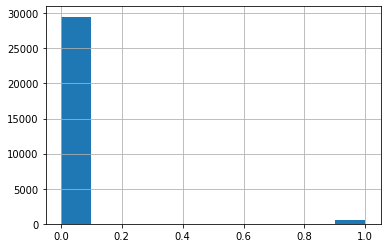

In [49]:
train_df['label'].hist()